Triplet Loss损失函数在mnist上做相似度计算   
triplet loss的核心包括三个部分    
1. anchor/positive/negative   
   代表三个输入图，尺寸相同，训练的目标是令anchor和positive距离最小化，同时anchor和negative距离最大化。以FaceRec为例，anchor和positive一般来自同一个人，而negative属于不同的另一个人。    
2. shared models
   通用的卷积模型，输入是单幅图像，输出是1维特征向量    
3. loss 
   $$
   L_i = [ (f(x_i^a) - f(x_i^p))^2 - (f(x_i^a) - f(x_i^n))^2 + \alpha] \\\\
   L = \sum_i^N [max( L_i, 0)] 
   $$
   其中$\alpha$是marginal超参

In [1]:
import mxnet as mx
import numpy as np
import os,sys
import time
from mxnet import nd
from mxnet.gluon import data as gdata
from mxnet import gluon
import random,cv2

%matplotlib inline
import matplotlib.pyplot as plt


batch_size = 32
ctx = mx.gpu()
sample_size = (32,32)
alpha = 1.0
base_lr = 0.01 
feat_dim = 2 
smallset_num = batch_size * 2
debug_flag = False

epoch_num = 100

if not os.path.exists('feat'):
    os.makedirs('feat')


feat_dim: 输出的特征图维度，设置成2时，训练阶段会保存测试机上类别分布图    
smallset_num: 调试阶段，每一类只使用少量样本，设置成-1时，采用全部样本集进行训练    

In [2]:


class SingleMNIST(gluon.data.Dataset):
    def __init__(self,fortrain,dataset_root="C:/dataset/mnist/",resize=sample_size):
        super(SingleMNIST,self).__init__()
        self.data_pairs = []
        labeldict = {}
        self.total = 0
        self.resize = resize
        if fortrain:
            ds_root = os.path.join(dataset_root,'train')
        else:
            ds_root = os.path.join(dataset_root,"test")
        for rdir, pdirs, names in os.walk(ds_root):
            for name in names:
                basename,ext = os.path.splitext(name)
                if ext != ".jpg":
                    continue
                fullpath = os.path.join(rdir,name)
                label = fullpath.split('\\')[-2]
                label = int(label)
                if smallset_num > 0 and ( label in labeldict.keys() ) and labeldict[label] >= smallset_num:
                    continue
                self.data_pairs.append((label,fullpath))
                if label in labeldict:
                    labeldict[label] += 1
                else:
                    labeldict[label] = 1
                self.total += 1
        return
    
    def __len__(self):
        return len(self.data_pairs)
        
    def __getitem__(self,idx):
        img = cv2.imread(self.data_pairs[idx][1],1)
        label = self.data_pairs[idx][0]
        
        img = cv2.resize(img, self.resize)
        

        img = np.float32(img)/255
        
        img = np.transpose(img,(2,0,1))
        
        return (img,label)

    
class TripletMNIST(gluon.data.Dataset):
    def __init__(self,fortrain,dataset_root="C:/dataset/mnist/",resize=sample_size):
        super(TripletMNIST,self).__init__()
        self.data_pairs = {}
        self.total = 0
        self.resize = resize
        if fortrain:
            ds_root = os.path.join(dataset_root,'train')
        else:
            ds_root = os.path.join(dataset_root,"test")
        for rdir, pdirs, names in os.walk(ds_root):
            for name in names:
                basename,ext = os.path.splitext(name)
                if ext != ".jpg":
                    continue
                fullpath = os.path.join(rdir,name)
                label = fullpath.split('\\')[-2]
                label = int(label)
                if smallset_num > 0 and (label in self.data_pairs) and len(self.data_pairs[label]) >= smallset_num:
                    continue 

                self.data_pairs.setdefault(label,[]).append(fullpath)
                self.total += 1
        self.class_num = len(self.data_pairs.keys())
        return
    
    def __len__(self):
        return self.total
        
    def __getitem__(self,idx):
        rds = np.random.randint(0,10000,size = 5)
        rd_anchor_cls, rd_anchor_idx = rds[0], rds[1]
        rd_anchor_cls = rd_anchor_cls % self.class_num
        rd_anchor_idx = rd_anchor_idx % len(self.data_pairs[rd_anchor_cls])
        
        rd_pos_cls, rd_pos_idx = rd_anchor_cls, rds[2]
        rd_pos_cls = rd_pos_cls % self.class_num
        rd_pos_idx = rd_pos_idx % len(self.data_pairs[rd_pos_cls])
        
        rd_neg_cls, rd_neg_idx = rds[3], rds[4]
        rd_neg_cls = rd_neg_cls % self.class_num
        if rd_neg_cls == rd_pos_cls:
            rd_neg_cls = (rd_neg_cls + 1)%self.class_num
        rd_neg_idx = rd_neg_idx % len(self.data_pairs[rd_neg_cls])
        
        img_anchor = cv2.imread(self.data_pairs[rd_anchor_cls][rd_anchor_idx],1)
        img_pos = cv2.imread(self.data_pairs[rd_pos_cls][rd_pos_idx],1)
        img_neg = cv2.imread(self.data_pairs[rd_neg_cls][rd_neg_idx],1)
        
        img_anchor = cv2.resize(img_anchor, self.resize)
        img_pos = cv2.resize(img_pos, self.resize)
        img_neg = cv2.resize(img_neg, self.resize)
        

        img_anchor = np.float32(img_anchor)/255
        img_pos = np.float32(img_pos)/255
        img_neg = np.float32(img_neg)/255
        
        img_anchor = np.transpose(img_anchor,(2,0,1))
        img_pos = np.transpose(img_pos,(2,0,1))
        img_neg = np.transpose(img_neg,(2,0,1))
        
        return (img_anchor, img_pos, img_neg)



if debug_flag:
    ds = TripletMNIST(fortrain=True)
    train_iter = gluon.data.DataLoader(ds,batch_size,shuffle=True,last_batch="rollover")
    for batch in train_iter:
        anchor, pos, neg = batch
        
        #print(anchor.shape)
        fig = plt.figure()
        for k in range(8):
            ax = fig.add_subplot(8,3,k*3+1)
            img = anchor[k].asnumpy() * 255   
            img = np.transpose(img,(1,2,0))
            img = np.uint8(img)
            ax.imshow(img)

            
            ax = fig.add_subplot(8,3,k*3+2)
            img = pos[k].asnumpy() * 255
            img = np.transpose(img,(1,2,0))
            img = np.uint8(img)
            ax.imshow(img)

            ax = fig.add_subplot(8,3,k*3+3)
            img = neg[k].asnumpy() * 255
            img = np.transpose(img,(1,2,0))
            img = np.uint8(img)
            ax.imshow(img)

        break
    plt.show()
train_ds = TripletMNIST(fortrain=True)
train_iter = gluon.data.DataLoader(train_ds,batch_size,shuffle=True,last_batch="rollover")
test_ds = TripletMNIST(fortrain=False)
test_iter = gluon.data.DataLoader(test_ds,batch_size,shuffle=False,last_batch="rollover")

feat_ds = SingleMNIST(fortrain=False)
feat_iter = gluon.data.DataLoader(feat_ds, batch_size, shuffle=False, last_batch="rollover")
    
print('train set: {}, test set: {} feat_set: {}'.format(len(train_ds), len(test_ds), len(feat_ds)))

train set: 640, test set: 640 feat_set: 640


In [3]:
class SHARED_NET(gluon.Block):
    def __init__(self,root='./models'):
        super(SHARED_NET,self).__init__()
        backbone = gluon.model_zoo.vision.vgg11(pretrained=True,root = root)
        self.net = gluon.nn.Sequential()
        for layer in backbone.features[0:-4]:
            self.net.add(layer)
        self.net.add(gluon.nn.Dense(256),
                    gluon.nn.Dense(feat_dim))
        self.net[-1].initialize(mx.initializer.Xavier())
        self.net[-2].initialize(mx.initializer.Xavier())
        return

    def forward(self, x):
        out = self.net(x)
        return out
    
    
def get_net(num_class,root):
    return SHARED_NET(num_class,root=root)


if debug_flag:
    fcn = SHARED_NET()
    fcn.collect_params().reset_ctx(ctx)
    x = mx.nd.random.uniform(0,1,[32,3] + list(sample_size),ctx=ctx)
    print('input: ',x.shape)
    y = fcn(x)
    print('output: ',y.shape)


训练阶段要每次要有$3xbatchSize$个图象经过网络，我们通过组成一个$3xbatchSize$的batch来实现，输出特征通过axis=0上分割获得anchor，pos和neg的特征向量

In [4]:
from mxnet import lr_scheduler
import pdb
import pickle

def show_feat(epoch,net, feat_iter):
    feats = []
    for batch in feat_iter:
        X,Y = batch
        out = net(X.as_in_context(ctx)).asnumpy()
        for y,f in zip(Y,out):
            y = y.asnumpy()[0]
            feats.append((y,f[0],f[1]))
           # pdb.set_trace()
    X = list(map(lambda d: d[1], feats))
    Y = list(map(lambda d: d[2], feats))
    #L = map(lambda d: d[0], feats)
    #markers = 'o,<,+,1,2,3,4,8,s,h,*,D'.split(',')
    cValue = [(1,0,0), (0,1,0), (0,0,1), \
              (0.5, 0, 0), (0,0.5,0), (0,0,0.5),\
              (1.0,1.0,0), (1.0,0,1.0), (0,1,1),\
              (0,0,0)] 
    L = []
    for f in feats:
        L.append(cValue[f[0]])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #pdb.set_trace()
    ax.scatter(X,Y,c=L,marker='s')
    plt.savefig('feat/%d.jpg'%epoch)
    return
        
        
def train_net(net, train_iter, valid_iter, feat_iter,batch_size, trainer, num_epochs, lr_sch, save_prefix):
    iter_num = 0
    for epoch in range(num_epochs):
        t0 = time.time()
        train_loss = []
        for batch in train_iter:
            iter_num += 1
            trainer.set_learning_rate(lr_sch(iter_num))
            anchor, pos, neg = batch
            #pdb.set_trace()
            X = nd.concat(anchor, pos, neg, dim=0) #combine three inputs along 0-dim to create one batch
            out = X.as_in_context(ctx)
            #print(out.shape)
            with mx.autograd.record(True):
                out = net(out)
                #out = out.as_in_context(mx.cpu())
                out_anchor = out[0:batch_size]
                out_pos = out[batch_size:batch_size*2]
                out_neg = out[batch_size*2 : batch_size*3]
                loss_anchor_pos = (out_anchor - out_pos)**2
                loss_anchor_neg = (out_anchor - out_neg)**2
                #print(loss_anchor_pos.max())
                loss = loss_anchor_pos - loss_anchor_neg
                loss = nd.relu(loss.sum(axis=1) + alpha).mean()
            loss.backward()
            train_loss.append( loss.asnumpy()[0] )
            trainer.step(1)
           # print("\titer {} train loss {}".format(iter_num,np.asarray(train_loss).mean()))
            nd.waitall()
        if (epoch % 10) == 0 and feat_dim == 2:
            show_feat(epoch,net,feat_iter)
        print("epoch {} lr {:>.5} loss {:>.5} cost {:>.3}sec".format(epoch,trainer.learning_rate, \
                                                             np.asarray(train_loss).mean(),time.time() - t0))
    

epoch 0 lr 0.0099 loss 0.51676 cost 5.64sec
epoch 1 lr 0.0098 loss 0.18289 cost 3.77sec
epoch 2 lr 0.0097 loss 0.17965 cost 3.76sec
epoch 3 lr 0.0096 loss 0.099185 cost 3.78sec
epoch 4 lr 0.0095 loss 0.11342 cost 3.8sec
epoch 5 lr 0.0094 loss 0.10642 cost 3.78sec
epoch 6 lr 0.0093 loss 0.099273 cost 3.76sec
epoch 7 lr 0.0092 loss 0.052797 cost 3.81sec
epoch 8 lr 0.0091 loss 0.0427 cost 3.77sec
epoch 9 lr 0.009 loss 0.033315 cost 3.77sec
epoch 10 lr 0.0089 loss 0.039496 cost 4.7sec
epoch 11 lr 0.0088 loss 0.027 cost 3.75sec
epoch 12 lr 0.0087 loss 0.070178 cost 3.74sec
epoch 13 lr 0.0086 loss 0.025219 cost 3.73sec
epoch 14 lr 0.0085 loss 0.032091 cost 3.78sec
epoch 15 lr 0.0084 loss 0.018097 cost 3.76sec
epoch 16 lr 0.0083 loss 0.01304 cost 3.72sec
epoch 17 lr 0.0082 loss 0.01952 cost 3.7sec
epoch 18 lr 0.0081 loss 0.021192 cost 3.72sec
epoch 19 lr 0.008 loss 0.014039 cost 3.7sec
epoch 20 lr 0.0079 loss 0.0090771 cost 4.64sec
epoch 21 lr 0.0078 loss 0.011745 cost 3.72sec
epoch 22 lr 0.0

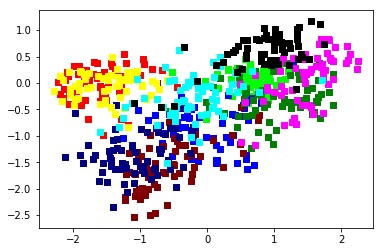

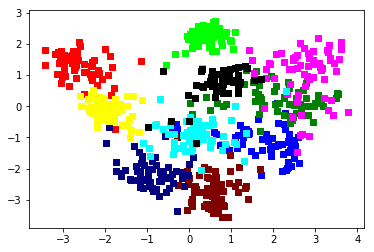

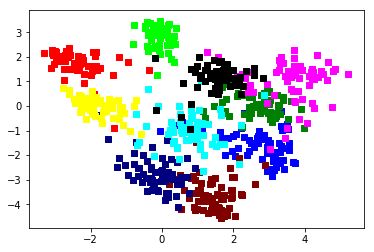

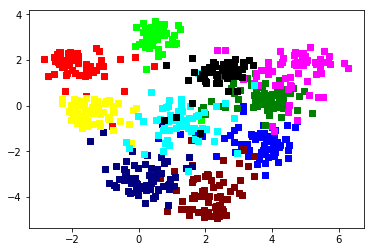

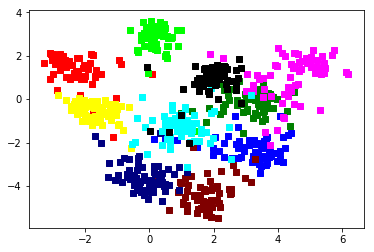

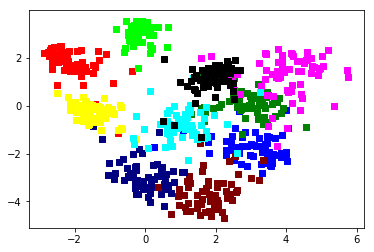

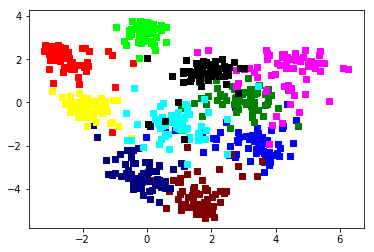

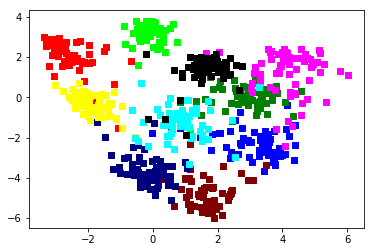

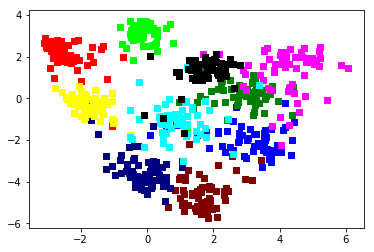

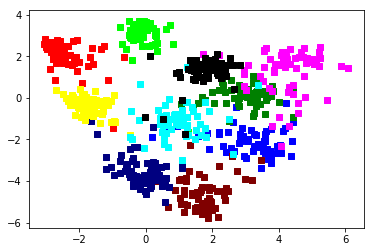

In [5]:
net = SHARED_NET()
net.collect_params().reset_ctx(ctx)
wd = 0.0005
trainer = gluon.Trainer(net.collect_params(),optimizer="sgd",optimizer_params={"wd":wd})

lr_plan = lr_scheduler.PolyScheduler(max_update= epoch_num * len(train_ds) // batch_size,base_lr=base_lr, pwr=1)
train_net(net, train_iter, test_iter, feat_iter, batch_size,trainer, epoch_num, lr_plan,"")

# 